
# Neural ODE Training

This notebook performs training of latent NODE models on sine wave data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0')

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

# Custom lib
from utils import gpu, asnp

## Data Generation: Sine Family

The point of this data is to provide a "library" of possible sine waves to train our classifier with.

In [3]:
data_path = "../data/sine_data_2021-04-09 00:13:41.249505"
generator = torch.load(data_path)['generator']

In [4]:
train_time, train_data = generator.get_train_set()
val_time, val_data = generator.get_val_set()

train_data = train_data.reshape(len(train_data), -1, 1)
val_data = val_data.reshape(len(val_data), -1, 1)

train_data_tt = gpu(train_data)
train_time_tt = gpu(train_time)

val_data_tt = gpu(val_data)
val_time_tt = gpu(val_time)

In [5]:
class SineSet(Dataset):
    def __init__(self, data, time):
        self.data = data
        self.time = time
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.time
    
train_dataset = SineSet(train_data_tt, train_time_tt)
val_dataset = SineSet(val_data_tt, val_time_tt)

train_loader = DataLoader(train_dataset, batch_size = 256, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size = len(val_dataset))

# Training loop

In [6]:
from model import LatentNeuralODEBuilder

model_args = {
    'obs_dim': 1,
    'rec_latent_dim': 8,
    'node_latent_dim': 4,
    
    'rec_gru_unit': 100,
    'rec_node_hidden': 100,
    'rec_node_layer': 2,
    'rec_node_act': 'Tanh',
    
    'latent_node_hidden': 100,
    'latent_node_layer': 2,
    'latent_node_act': 'Tanh',
    
    'dec_type': 'NN',
    'dec_hidden': 100,
    'dec_layer': 1,
    'dec_act': 'ReLU',
}

elbo_type = 'miwae'

base_model = LatentNeuralODEBuilder(**model_args)
model = base_model.build_latent_node(elbo_type).to(device)

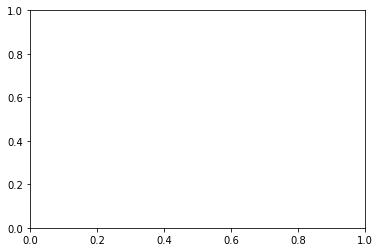

In [7]:
from train import TrainingLoop
from visualize_sine import plot_training_sine

main = TrainingLoop(model, train_loader, val_loader, plot_training_sine)

In [8]:
from torch.optim.lr_scheduler import ExponentialLR

lr = 1e-3

parameters = (model.parameters())
optimizer = optim.Adamax(parameters, lr=lr)
scheduler = ExponentialLR(optimizer, 0.995)

In [9]:
train_args = {
    'max_epoch': 500,
    'l_std': 0.1,
    'clip_norm': 5,
    'model_atol': 1e-4,
    'model_rtol': 1e-3,
    'plt_args': {'n_plot': 2},
    'K': 8,
    'M': 3,
    'method': 'dopri5'
}

In [1]:
main.train(optimizer, train_args, scheduler, plt_traj=True, plt_loss=True)

In [21]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'data_path': data_path,
    'model_args': model_args,
    'train_args': train_args,
    'train_obj': main,
}, '../models/sine_iwlatode_{}'.format(datetime.now()))